# Loading the Model
In this notebook we will try loading the model to make sure it properly works

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.utils as vutils
import torch.optim as optim
import numpy as np
from src.config import PROCESSED_DATA_DIR
import matplotlib.pyplot as plt

from src.config import batch_size, image_size, nc, nz, ngf, ndf, num_epochs, lr, beta1, ngpu, MODELS_DIR
model_dir = MODELS_DIR / 'generator.pth'

2025-04-16 22:28:54.943 | INFO     | src.config:<module>:10 - PROJ_ROOT path is: /Users/danieltiourine/Git/ai-art-generator


In [2]:
print(model_dir)

/Users/danieltiourine/Git/ai-art-generator/models/generator.pth


In [3]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()

        )

    def forward(self, input):
        return self.main(input)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator(ngpu=1).to(device)  # Use the same ngpu value as during training

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
netG = Generator(ngpu=1).to(device)  # Use the same ngpu value as during training
 
if device == torch.device("cpu"):
    netG.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu'))) 
else:
    netG.load_state_dict(torch.load(model_dir))

# Generating Images with Loaded Model

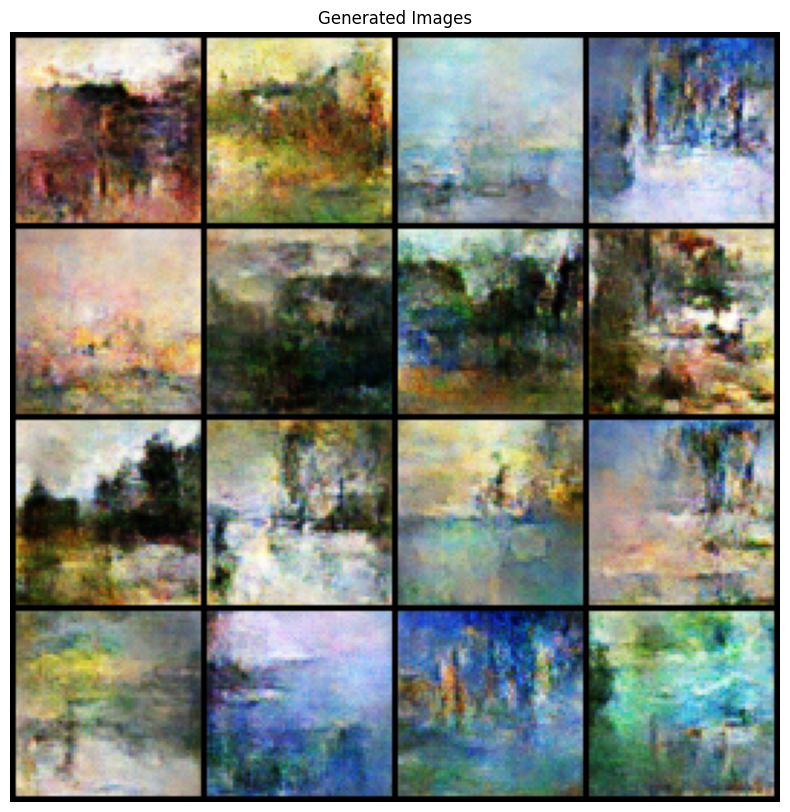

In [16]:
# Make sure your model is in evaluation mode
netG.eval()

# Set the number of images you want to generate
num_images = 16
batch_size = 16  # You can adjust this based on your GPU memory

# Create random noise vectors (this is what the generator transforms into images)
noise = torch.randn(num_images, nz, 1, 1, device=device)

# Generate images
with torch.no_grad():  # Disable gradient calculations for inference
    generated_images = netG(noise)

# Display the generated images using matplotlib
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

# Create a grid of images
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(
    vutils.make_grid(generated_images.detach().cpu(), 
                    nrow=4,  # Number of images per row
                    padding=2, 
                    normalize=True), 
    (1, 2, 0)  # Change from PyTorch's CHW format to matplotlib's HWC format
))
plt.show()

# If you want to save individual images to files
from PIL import Image
import torchvision.transforms as transforms

# Convert to PIL images and save
# for i, img in enumerate(generated_images):
#     # Transform tensor to PIL Image
#     img = img.detach().cpu()
#     img = img * 0.5 + 0.5  # Unnormalize if your output is in [-1,1] range
#     img = transforms.ToPILImage()(img)
#     
#     # Save image
#     img.save(f"generated_image_{i}.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99433196..0.987197].


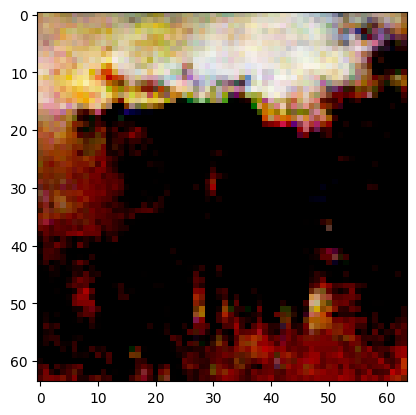

In [25]:
sample_image = generated_images[0]
sample_image_for_matplotlib = sample_image.permute(1, 2, 0)
plt.imshow(sample_image_for_matplotlib)
plt.show()

In [26]:
sample_image

tensor([[[ 0.7094,  0.7329,  0.7257,  ...,  0.7470,  0.6796,  0.5555],
         [ 0.7498,  0.7414,  0.7581,  ...,  0.6563,  0.7378,  0.6267],
         [ 0.7568,  0.8200,  0.8084,  ...,  0.6953,  0.7391,  0.6172],
         ...,
         [ 0.2659,  0.3276, -0.0345,  ...,  0.2605,  0.4865,  0.7231],
         [ 0.1957,  0.4608,  0.1481,  ...,  0.7249,  0.5473,  0.6833],
         [ 0.2901,  0.4353,  0.4724,  ...,  0.5800,  0.6260,  0.4198]],

        [[ 0.5599,  0.6835,  0.6294,  ...,  0.5891,  0.6019,  0.3868],
         [ 0.5458,  0.5901,  0.6213,  ...,  0.6105,  0.6722,  0.4270],
         [ 0.5732,  0.7039,  0.6303,  ...,  0.5003,  0.4870,  0.4202],
         ...,
         [-0.0858, -0.1348, -0.4165,  ..., -0.3888, -0.1538,  0.1992],
         [-0.0430, -0.0014, -0.2245,  ..., -0.1902, -0.0729,  0.0879],
         [-0.0451,  0.0240, -0.0288,  ...,  0.0791,  0.1282,  0.1059]],

        [[ 0.3458,  0.4447,  0.3673,  ...,  0.3734,  0.3962,  0.1975],
         [ 0.3806,  0.4761,  0.4364,  ...,  0

In [29]:
import base64
import io 

def tensor_to_base64(tensor_image):
    # Move to CPU if on GPU
    tensor_image = tensor_image.detach().cpu()
    
    # Remove batch dimension if present
    if tensor_image.dim() == 4 and tensor_image.size(0) == 1:
        tensor_image = tensor_image[0]
    
    # Convert from [-1, 1] to [0, 1] range if needed
    if tensor_image.min() < 0:
        tensor_image = (tensor_image + 1) / 2.0
    
    # Ensure values are clamped between 0 and 1
    tensor_image = torch.clamp(tensor_image, 0, 1)
    
    # Convert to PIL Image (automatically handles permute)
    pil_image = transforms.ToPILImage()(tensor_image)
    
    # Save to bytes buffer
    buffer = io.BytesIO()
    pil_image.save(buffer, format="PNG")
    buffer.seek(0)
    
    # Convert to base64 string
    img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
    
    return img_str

In [30]:
img_str = tensor_to_base64(sample_image)

In [32]:
with open('img.txt', 'w') as f:
    f.write(img_str)
    